In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, force=False):
    
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  return filename

train_filename = maybe_download('train.tar.gz')
test_filename = maybe_download('test.tar.gz')

In [3]:
from scipy.io import loadmat
def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('train_32x32.mat')
X_test, y_test = load_data('test_32x32.mat')

print("Training Set", X_train.shape, y_train.shape)
print("Test Set", X_test.shape, y_test.shape)

Training Set (32, 32, 3, 73257) (73257, 1)
Test Set (32, 32, 3, 26032) (26032, 1)


In [4]:
#Transpose the image arrays
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("Training Set", X_train.shape)
print("Test Set", X_test.shape)
print('')

# Calculate the total number of images
num_images = X_train.shape[0] + X_test.shape[0]

print("Total Number of Images", num_images)

Training Set (73257, 32, 32, 3)
Test Set (26032, 32, 32, 3)

Total Number of Images 99289


In [5]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

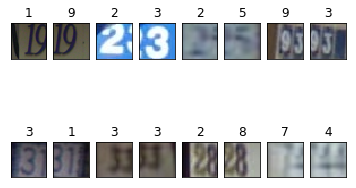

In [6]:
# Plot some training set images
plot_images(X_train, y_train, 2, 8)

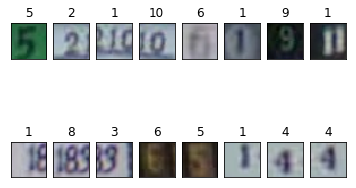

In [7]:
# Plot some test set images
plot_images(X_test, y_test, 2, 8)

In [8]:
print(np.unique(y_train))

[ 1  2  3  4  5  6  7  8  9 10]


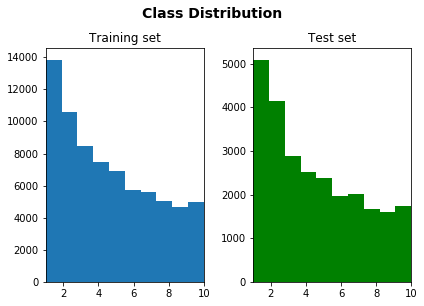

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(y_test, color='g', bins=10)
ax2.set_title("Test set")

fig.tight_layout()

In [10]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [11]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


In [12]:
#Splitting the Training to Train+Validation
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.13, random_state=7)

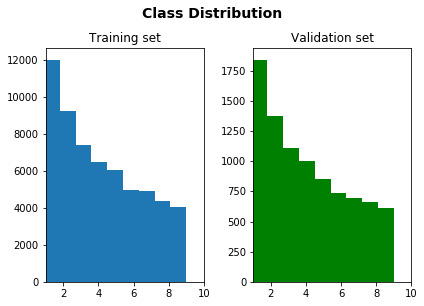

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(y_val, color='g', bins=10)
ax2.set_title("Validation set")

fig.tight_layout()

In [15]:
y_train.shape, y_val.shape, y_test.shape

((63733,), (9524,), (26032,))

In [16]:
#Grayscale Conversion
#To speed up our experiments we will convert our images from RGB to Grayscale, which grately reduces the amount of data we will have to process.

In [17]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

In [18]:
train_greyscale = rgb2gray(X_train).astype(np.float32)
test_greyscale = rgb2gray(X_test).astype(np.float32)
val_greyscale = rgb2gray(X_val).astype(np.float32)

In [19]:
print("Training Set", train_greyscale.shape)
print("Validation Set", val_greyscale.shape)
print("Test Set", test_greyscale.shape)
print('')

Training Set (63733, 32, 32, 1)
Validation Set (9524, 32, 32, 1)
Test Set (26032, 32, 32, 1)



In [20]:
#Ploting the Grayscale Image before normalization

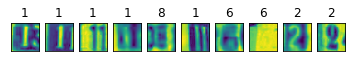

In [21]:
plot_images(train_greyscale, y_train, 1, 10)

In [22]:
# Calculate the mean on the training data
train_mean = np.mean(train_greyscale, axis=0)

# Calculate the std on the training data
train_std = np.std(train_greyscale, axis=0)

# Subtract it equally from all splits
train_greyscale_norm = (train_greyscale - train_mean) / train_std
test_greyscale_norm = (test_greyscale - train_mean)  / train_std
val_greyscale_norm = (val_greyscale - train_mean) / train_std

In [23]:
#Plotting After Normalization

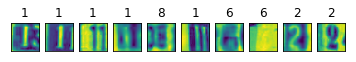

In [24]:
plot_images(train_greyscale_norm, y_train, 1, 10)

In [25]:
#One Hot Label Encoding
#Apply One Hot Encoding to make label suitable for CNN Classification

In [26]:
from sklearn.preprocessing import OneHotEncoder
 
# Fit the OneHotEncoder
enc = OneHotEncoder().fit(y_train.reshape(-1, 1))

# Transform the label values to a one-hot-encoding scheme
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
y_val = enc.transform(y_val.reshape(-1, 1)).toarray()

print("Training set", y_train.shape)
print("Validation set", y_val.shape)
print("Test set", y_test.shape)

Training set (63733, 10)
Validation set (9524, 10)
Test set (26032, 10)


C:\Users\Bhanushree\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [27]:
import h5py

# Create file
h5f = h5py.File('SVHN_grey.h5', 'w')

# Store the datasets
h5f.create_dataset('X_train', data=train_greyscale_norm)
h5f.create_dataset('y_train', data=y_train)
h5f.create_dataset('X_test', data=test_greyscale_norm)
h5f.create_dataset('y_test', data=y_test)
h5f.create_dataset('X_val', data=val_greyscale_norm)
h5f.create_dataset('y_val', data=y_val)

# Close the file
h5f.close()

In [28]:
from __future__ import absolute_import
from __future__ import print_function
import os
import time
from datetime import timedelta
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # Set default figure size

In [29]:
TENSORBOARD_SUMMARIES_DIR = '/tmp/svhn_classifier_logs'

In [30]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Plot nrows * ncols images from images and annotate the images
    """
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Predictions are not passed
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))
        
        # When predictions are passed, display labels + predictions
        else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])  
            
        # Display the image
        ax.imshow(images[i,:,:,0], cmap='binary')
        
        # Annotate the image
        ax.set_title(title)
        
        # Do not overlay a grid
        ax.set_xticks([])
        ax.set_yticks([])

In [31]:
def prepare_log_dir():
    '''Clears the log files then creates new directories to place
        the tensorbard log file.''' 
    if tf.gfile.Exists(TENSORBOARD_SUMMARIES_DIR):
        tf.gfile.DeleteRecursively(TENSORBOARD_SUMMARIES_DIR)
    tf.gfile.MakeDirs(TENSORBOARD_SUMMARIES_DIR)

In [32]:
def get_batch(X, y, batch_size=512):
    for i in np.arange(0, y.shape[0], batch_size):
        end = min(X.shape[0], i + batch_size)
        yield(X[i:end],y[i:end])


In [33]:
comp = 32*32
tf.logging.set_verbosity(tf.logging.INFO)

# Our application logic will be added here
x = tf.placeholder(tf.float32, shape = [None, 32, 32, 1], name='Input_Data')
y = tf.placeholder(tf.float32, shape = [None, 10], name='Input_Labels')
y_cls = tf.argmax(y, 1)

discard_rate = tf.placeholder(tf.float32, name='Discard_rate')
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [51]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())